In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mlxtend.data import loadlocal_mnist
from scipy.stats import norm
from scipy.stats import bernoulli
import math

# training set
A, b = loadlocal_mnist(
        images_path='drive/My Drive/CS 498 AML/data/train-images.idx3-ubyte', 
        labels_path='drive/My Drive/CS 498 AML/data/train-labels.idx1-ubyte')
b = np.array(b)
b = b.astype(np.float)
# test set
X, y = loadlocal_mnist(
        images_path='drive/My Drive/CS 498 AML/data/t10k-images.idx3-ubyte', 
        labels_path='drive/My Drive/CS 498 AML/data/t10k-labels.idx1-ubyte')
y = np.array(y)
y = y.astype(np.float)

trainret = cv2.threshold(A,128,255,cv2.THRESH_BINARY)
testret = cv2.threshold(X,128,255,cv2.THRESH_BINARY)

traindata = np.array(trainret[1])
testdata = np.array(testret[1])

def resize(data):
  resized = np.empty((len(data), 400), dtype=np.uint8)
  for i in range(len(data)):
    img = data[i].reshape(28,28)
    x,y,w,h = cv2.boundingRect(img)
    num_only = img[y:y+h,x:x+w]
    stretched = cv2.resize(num_only, (20, 20))
    resized[i] = np.array(np.ravel(stretched))
  return (resized)

def get_trained_model(traindata, trainlabel, model = True): # traindata is (number of samples , features)
    if model:
      white = np.full((10,len(traindata[0])), -2000) # A good guess
      black = np.full((10,len(traindata[0])), 2000)
      traindata = np.concatenate((traindata, white), axis=0)
      traindata = np.concatenate((traindata, black), axis=0)    
      for i in range(2):
        dummy = np.array(range(10))
        trainlabel = np.concatenate((trainlabel, dummy), axis=0)
      num = np.empty(10, dtype=np.ndarray) # num has 10 objects (i), each object contains samples of i
      amt = np.empty(10, dtype=float) # amt keeps track of how many samples are in each i
      lamt = np.empty(10, dtype=float) # log of amt
      nmean = np.empty(10, dtype=np.ndarray) # nmean has 10 objects (i), each object contains means of each i
      nvar = np.empty(10, dtype=np.ndarray) # nvar has 10 objects (i), each object contains var of each i
      ly = np.empty(10, dtype=np.ndarray) # ly keeps track of fraction of each i from total sample count
      for i in range(10):
        num[i] = traindata[trainlabel == i] # num[i] contains all numbers for label i
        amt[i] = len(num[i])
      total = np.sum(amt)
      for j in range(num.shape[0]):
        nmean[j] = np.array(np.mean(num[j], axis=0)) # nmean[i] contains all mean of each feature of i
        nvar[j] = np.var(num[j], axis=0) # nvar[i] contains all var of each feature of i
      amt = np.array(amt)
      lamt = np.log(np.divide(amt, total))
      return nmean, nvar, lamt
    else:
      white = np.full((10,len(traindata[0])), 1) # A good guess
      traindata = np.concatenate((traindata, white), axis=0)  
      for i in range(1):
        dummy = np.array(range(10))
        trainlabel = np.concatenate((trainlabel, dummy), axis=0)
      num = np.empty(10, dtype=np.ndarray) # num has 10 objects (i), each object contains samples of i
      amt = np.empty(10, dtype=float) # amt keeps track of how many samples are in each i
      lamt = np.empty(10, dtype=float) # log of amt
      nmean = np.empty(10, dtype=np.ndarray) # nmean has 10 objects (i), each object contains means of each i
      ly = np.empty(10, dtype=np.ndarray) # ly keeps track of fraction of each i from total sample count
      for i in range(10):
        num[i] = traindata[trainlabel == i] # num[i] contains all numbers for label i
        amt[i] = len(num[i])
      total = np.sum(amt)
      for j in range(num.shape[0]):
        nmean[j] = np.array(np.mean(num[j], axis=0)) # nmean[i] contains all mean of each feature of i
      amt = np.array(amt)
      lamt = np.log(np.divide(amt, total))
#       print("nmean: \n", nmean)
      return nmean, lamt

def norm_predict(testdata, nmean, nvar, lamt):
  predict = np.empty(10, dtype=object)
  for j in range(len(nmean)): # labels
      predict[j] = np.log(np.array([norm.pdf(testdata[:, k], nmean[j][k], np.sqrt(nvar[j][k])) for k in range(len(nmean[0]))]).T) # predict[i][j] contains norm pdf of 28x28 features of label i
  nbayes = np.array([np.sum(predict[i], axis=1) + lamt[i] for i in range(len(nmean))]).T
  predictions = np.array([np.argmax(nbayes, axis=1)])
  return predictions

def ber_predict(testdata, nmean, lamt):
  predict = np.empty(10, dtype=object)
  for j in range(len(nmean)): # labels
      predict[j] = np.array([bernoulli.logpmf(testdata[:, k]/255, nmean[j][k]/255, loc=0) for k in range(len(nmean[0]))]).T # predict[i][j] contains norm pdf of 28x28 features of label i
  nbayes = np.array([np.sum(predict[i], axis=1) + lamt[i] for i in range(len(nmean))]).T
  predictions = np.array([np.argmax(nbayes, axis=1)])
  return predictions

def evaluate(testlabel, predictions):
  return np.sum(testlabel == predictions)/testlabel.shape[0]

bounded = resize(A)
trainret = cv2.threshold(bounded,128,255,cv2.THRESH_BINARY)
btrain = np.array(trainret[1])

boundedtest = resize(X)
trainrettest = cv2.threshold(boundedtest,128,255,cv2.THRESH_BINARY)
btest = np.array(trainrettest[1])

In [0]:
# Normal Untouched
nmean, nvar, lamt = get_trained_model(traindata, b)
predictions = norm_predict(testdata, nmean, nvar, lamt)
acc = evaluate(y, predictions)
print("Normal Dist Untocuhed: ", acc)

Normal Dist Untocuhed:  0.7914


In [0]:
# Bernoulli Untouched
nmean, lamt = get_trained_model(traindata, b, False)
predictions = ber_predict(traindata, nmean, lamt)
acc = evaluate(b, predictions)
print("Bernoulli Dist Untocuhed: ", acc)

Bernoulli Dist Untocuhed:  0.8374666666666667


In [0]:
# Normal Bounded
nmean, nvar, lamt = get_trained_model(btrain, b)
predictions = norm_predict(btest, nmean, nvar, lamt)
acc = evaluate(y, predictions)
print("Normal Dist Stretched Bounding Box: ", acc)

Normal Dist Stretched Bounding Box:  0.8271


In [0]:
# Bernoulli Bounded
nmean, lamt = get_trained_model(btrain, b, False)
predictions = ber_predict(btest, nmean, lamt)
acc = evaluate(y, predictions)
print("Bernoulli Dist Stretched Bounding Box: ", acc)

Bernoulli Dist Stretched Bounding Box:  0.828


In [0]:
from sklearn.ensemble import RandomForestClassifier

print("With untouch data")
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10,max_depth=4)
rfc.fit(A, b)
print("Random Forest with tree =10, depth = 4  : ", rfc.score(X, y))
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10,max_depth=16)
rfc.fit(A, b)
print("Random Forest with tree =10, depth = 16 : ", rfc.score(X, y))
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=30,max_depth=4)
rfc.fit(A, b)
print("Random Forest with tree =30, depth = 4  : ", rfc.score(X, y))
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=30,max_depth=16)
rfc.fit(A, b)
print("Random Forest with tree =30, depth = 16 : ", rfc.score(X, y))

print("\nWith stretched data")
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10,max_depth=4)
rfc.fit(btrain, b)
print("Random Forest with tree =10, depth = 4  : ", rfc.score(btest, y))
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10,max_depth=16)
rfc.fit(btrain, b)
print("Random Forest with tree =10, depth = 16 : ", rfc.score(btest, y))
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=30,max_depth=4)
rfc.fit(btrain, b)
print("Random Forest with tree =30, depth = 4  : ", rfc.score(btest, y))
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=30,max_depth=16)
rfc.fit(btrain, b)
print("Random Forest with tree =30, depth = 16 : ", rfc.score(btest, y))

With untouch data
Random Forest with tree =10, depth = 4  :  0.7841
Random Forest with tree =10, depth = 16 :  0.9469
Random Forest with tree =30, depth = 4  :  0.8014
Random Forest with tree =30, depth = 16 :  0.9611

With stretched data
Random Forest with tree =10, depth = 4  :  0.7102
Random Forest with tree =10, depth = 16 :  0.9501
Random Forest with tree =30, depth = 4  :  0.7645
Random Forest with tree =30, depth = 16 :  0.9644


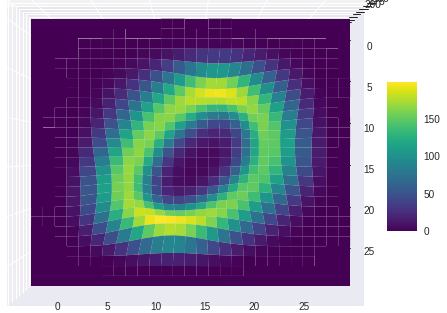

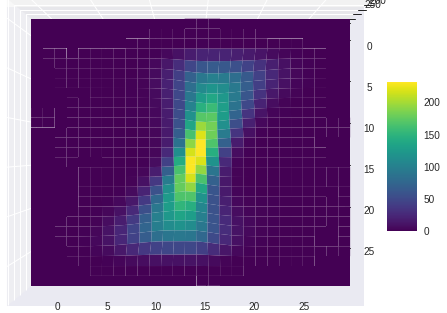

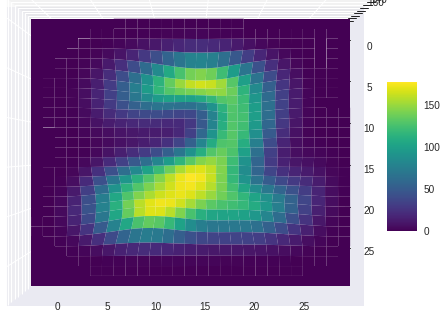

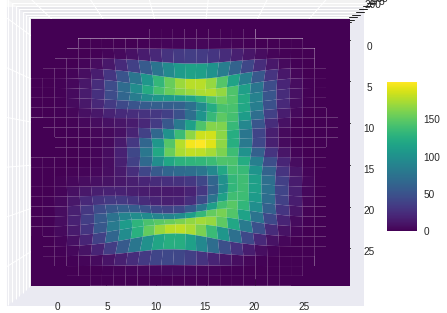

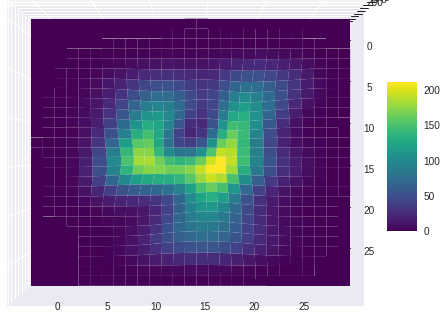

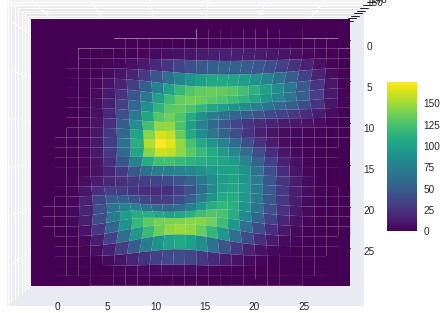

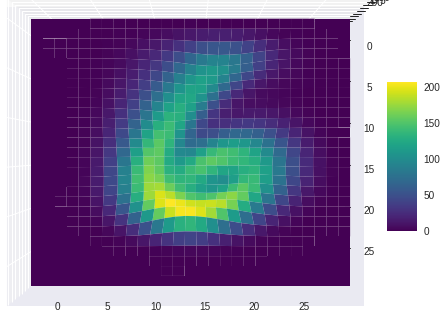

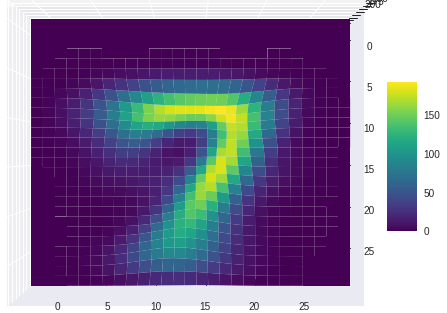

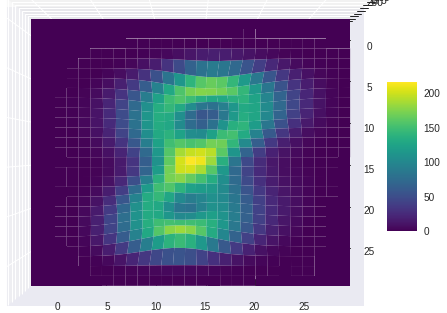

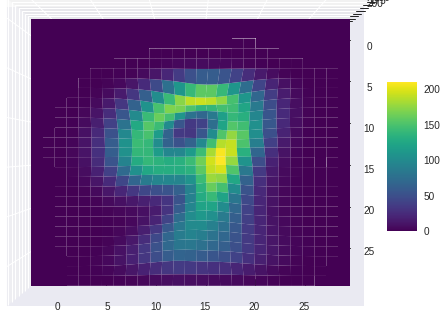

In [0]:
def get_trained_model(traindata, trainlabel, model = True): # traindata is (number of samples , features)
    if model:
      white = np.full((10,len(traindata[0])), -2000) # A good guess
      black = np.full((10,len(traindata[0])), 2000)
      traindata = np.concatenate((traindata, white), axis=0)
      traindata = np.concatenate((traindata, black), axis=0)    
      for i in range(2):
        dummy = np.array(range(10))
        trainlabel = np.concatenate((trainlabel, dummy), axis=0)
      num = np.empty(10, dtype=np.ndarray) # num has 10 objects (i), each object contains samples of i
      amt = np.empty(10, dtype=float) # amt keeps track of how many samples are in each i
      lamt = np.empty(10, dtype=float) # log of amt
      nmean = np.empty(10, dtype=np.ndarray) # nmean has 10 objects (i), each object contains means of each i
      nvar = np.empty(10, dtype=np.ndarray) # nvar has 10 objects (i), each object contains var of each i
      ly = np.empty(10, dtype=np.ndarray) # ly keeps track of fraction of each i from total sample count
      for i in range(10):
        num[i] = traindata[trainlabel == i] # num[i] contains all numbers for label i
        amt[i] = len(num[i])
      total = np.sum(amt)
      for j in range(num.shape[0]):
        nmean[j] = np.array(np.mean(num[j], axis=0)) # nmean[i] contains all mean of each feature of i
        nvar[j] = np.var(num[j], axis=0) # nvar[i] contains all var of each feature of i
      amt = np.array(amt)
      lamt = np.log(np.divide(amt, total))
      return nmean, nvar, lamt
    else:
      white = np.full((10,len(traindata[0])), 1) # A good guess
      traindata = np.concatenate((traindata, white), axis=0)  
      for i in range(1):
        dummy = np.array(range(10))
        trainlabel = np.concatenate((trainlabel, dummy), axis=0)
      num = np.empty(10, dtype=np.ndarray) # num has 10 objects (i), each object contains samples of i
      amt = np.empty(10, dtype=float) # amt keeps track of how many samples are in each i
      lamt = np.empty(10, dtype=float) # log of amt
      nmean = np.empty(10, dtype=np.ndarray) # nmean has 10 objects (i), each object contains means of each i
      ly = np.empty(10, dtype=np.ndarray) # ly keeps track of fraction of each i from total sample count
      for i in range(10):
        num[i] = traindata[trainlabel == i] # num[i] contains all numbers for label i
        amt[i] = len(num[i])
      total = np.sum(amt)
      for j in range(num.shape[0]):
        nmean[j] = np.array(np.mean(num[j], axis=0)) # nmean[i] contains all mean of each feature of i
      amt = np.array(amt)
      lamt = np.log(np.divide(amt, total))
#       print("nmean: \n", nmean)
      return nmean, lamt

nmean, nvar, lamt = get_trained_model(traindata, b)
samplev = nmean[9].reshape(28,28)
def prepare(data):
  x = np.empty((len(data),len(data)))
  y = np.empty((len(data),len(data)))
  z = np.empty((len(data),len(data)))
  for i in range(len(data)):
    x[i] = np.full(len(data), i)
    y[i] = np.arange(len(data))
  for i in range(len(data)):
    for j in range(len(data)):
      z[i][j] = data[i][j]
  x = x.ravel()+1
  y = y.ravel()+1
  z = z.ravel()
  return x, y, z



def plotavg(data,number):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  x, y, z = prepare(data)
  X, Y = np.meshgrid(np.arange(28), np.arange(28))
  d = {'X': x, 'Y': y, 'Z': z}
  df = pd.DataFrame(d)

  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(X, Y, data, cmap=plt.cm.viridis, linewidth=0)
  ax.view_init(elev=-90, azim=-90)
  ax.dist=6
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.savefig('drive/My Drive/CS 498 AML/HW1/no%s.png' % number, dpi=300, format='png')
  plt.show()
  
## PLOT  
for i in range(len(nmean)):
  samplev = nmean[i].reshape(28,28)
  plotavg(samplev,i)

In [0]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mlxtend.data import loadlocal_mnist
from scipy.stats import norm
from scipy.stats import bernoulli
import math

# training set
A, b = loadlocal_mnist(
        images_path='drive/My Drive/CS 498 AML/data/train-images.idx3-ubyte', 
        labels_path='drive/My Drive/CS 498 AML/data/train-labels.idx1-ubyte')
b = np.array(b)
b = b.astype(np.float)
# test set
X, y = loadlocal_mnist(
        images_path='drive/My Drive/CS 498 AML/data/t10k-images.idx3-ubyte', 
        labels_path='drive/My Drive/CS 498 AML/data/t10k-labels.idx1-ubyte')
y = np.array(y)
y = y.astype(np.float)

trainret = cv2.threshold(A,128,255,cv2.THRESH_BINARY)
testret = cv2.threshold(X,128,255,cv2.THRESH_BINARY)

traindata = np.array(trainret[1])
testdata = np.array(testret[1])

def resize(data):
  resized = np.empty((len(data), 400), dtype=np.uint8)
  for i in range(len(data)):
    img = data[i].reshape(28,28)
    x,y,w,h = cv2.boundingRect(img)
    num_only = img[y:y+h,x:x+w]
    stretched = cv2.resize(num_only, (20, 20))
    resized[i] = np.array(np.ravel(stretched))
  return (resized)

def get_trained_model(traindata, trainlabel, i, model = True): # traindata is (number of samples , features)
    if model:
      white = np.full((10,len(traindata[0])), -i) # A good guess
      black = np.full((10,len(traindata[0])), i)
      traindata = np.concatenate((traindata, white), axis=0)
      traindata = np.concatenate((traindata, black), axis=0)    
      for i in range(2):
        dummy = np.array(range(10))
        trainlabel = np.concatenate((trainlabel, dummy), axis=0)
      num = np.empty(10, dtype=np.ndarray) # num has 10 objects (i), each object contains samples of i
      amt = np.empty(10, dtype=float) # amt keeps track of how many samples are in each i
      lamt = np.empty(10, dtype=float) # log of amt
      nmean = np.empty(10, dtype=np.ndarray) # nmean has 10 objects (i), each object contains means of each i
      nvar = np.empty(10, dtype=np.ndarray) # nvar has 10 objects (i), each object contains var of each i
      ly = np.empty(10, dtype=np.ndarray) # ly keeps track of fraction of each i from total sample count
      for i in range(10):
        num[i] = traindata[trainlabel == i] # num[i] contains all numbers for label i
        amt[i] = len(num[i])
      total = np.sum(amt)
      for j in range(num.shape[0]):
        nmean[j] = np.array(np.mean(num[j], axis=0)) # nmean[i] contains all mean of each feature of i
        nvar[j] = np.var(num[j], axis=0) # nvar[i] contains all var of each feature of i
      amt = np.array(amt)
      lamt = np.log(np.divide(amt, total))
      return nmean, nvar, lamt
    else:
      white = np.full((10,len(traindata[0])), 1) # A good guess
      traindata = np.concatenate((traindata, white), axis=0)  
      for i in range(1):
        dummy = np.array(range(10))
        trainlabel = np.concatenate((trainlabel, dummy), axis=0)
      num = np.empty(10, dtype=np.ndarray) # num has 10 objects (i), each object contains samples of i
      amt = np.empty(10, dtype=float) # amt keeps track of how many samples are in each i
      lamt = np.empty(10, dtype=float) # log of amt
      nmean = np.empty(10, dtype=np.ndarray) # nmean has 10 objects (i), each object contains means of each i
      ly = np.empty(10, dtype=np.ndarray) # ly keeps track of fraction of each i from total sample count
      for i in range(10):
        num[i] = traindata[trainlabel == i] # num[i] contains all numbers for label i
        amt[i] = len(num[i])
      total = np.sum(amt)
      for j in range(num.shape[0]):
        nmean[j] = np.array(np.mean(num[j], axis=0)) # nmean[i] contains all mean of each feature of i
      amt = np.array(amt)
      lamt = np.log(np.divide(amt, total))
#       print("nmean: \n", nmean)
      return nmean, lamt

def norm_predict(testdata, nmean, nvar, lamt):
  predict = np.empty(10, dtype=object)
  for j in range(len(nmean)): # labels
      predict[j] = np.log(np.array([norm.pdf(testdata[:, k], nmean[j][k], np.sqrt(nvar[j][k])) for k in range(len(nmean[0]))]).T) # predict[i][j] contains norm pdf of 28x28 features of label i
  nbayes = np.array([np.sum(predict[i], axis=1) + lamt[i] for i in range(len(nmean))]).T
  predictions = np.array([np.argmax(nbayes, axis=1)])
  return predictions

def ber_predict(testdata, nmean, lamt):
  predict = np.empty(10, dtype=object)
  for j in range(len(nmean)): # labels
      predict[j] = np.array([bernoulli.logpmf(testdata[:, k]/255, nmean[j][k]/255, loc=0) for k in range(len(nmean[0]))]).T # predict[i][j] contains norm pdf of 28x28 features of label i
  nbayes = np.array([np.sum(predict[i], axis=1) + lamt[i] for i in range(len(nmean))]).T
  predictions = np.array([np.argmax(nbayes, axis=1)])
  return predictions

def evaluate(testlabel, predictions):
  return np.sum(testlabel == predictions)/testlabel.shape[0]

bounded = resize(A)
trainret = cv2.threshold(bounded,128,255,cv2.THRESH_BINARY)
btrain = np.array(trainret[1])

boundedtest = resize(X)
trainrettest = cv2.threshold(boundedtest,128,255,cv2.THRESH_BINARY)
btest = np.array(trainrettest[1])

acc = np.empty(31)
# Normal Untouched
for i in range(len(acc)):
  nmean, nvar, lamt = get_trained_model(traindata, b, i*200)
  predictions = norm_predict(testdata, nmean, nvar, lamt)
  acc[i] = evaluate(y, predictions)
print("Normal Dist Untocuhed:\n", acc)


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log


Normal Dist Untocuhed:
 [0.098  0.7223 0.7506 0.7647 0.7747 0.7827 0.7882 0.7898 0.7919 0.7923
 0.7914 0.7878 0.7844 0.7798 0.7748 0.7695 0.7619 0.7546 0.7461 0.7356
 0.7267 0.7163 0.704  0.6916 0.6779 0.6661 0.6519 0.638  0.6227 0.6089
 0.5928]
